# Analyzing GPT-Neo 1.3B
After a series of fixes to the pair engine, trying to get a new understanding of what's real.

In [1]:
from collections import OrderedDict
from importlib import reload

import numpy as np
import pandas as pd
from tqdm import tqdm
import graph_tool.all as gt
import matplotlib.pyplot as plt

from gptomics import graph, plot

In [2]:
def read_comps(filename, **kwargs):
    return pd.read_csv(filename, index_col=0, compression="gzip", **kwargs)

In [3]:
orig_df = read_comps("../data/bad_layernorm/gpt-neo-1.3B-compositions.csv.gz")
wd_df = read_comps("../data/slurm/gpt-neo-1.3B_compositions.csv.gz")
od_df = read_comps("../data/slurm/gpt-neo-1.3B_compositions_orig.csv.gz")

In [4]:
wd_df.shape

(258540, 8)

In [5]:
wd_df[wd_df.src_block == wd_df.dst_block].shape[0] / 24

66.0

In [6]:
wd_df[wd_df.src_block != wd_df.dst_block].shape[0] / (24 * 23 / 2)

931.0

In [7]:
dataframes = OrderedDict(
    old_orig_denom=orig_df,
    new_denom=wd_df,
    new_orig_denom=od_df,
)

In [8]:
def basic_value_plot(df, bounds=False):
    plt.hist(df.term_value, bins=50, color='k')
    plt.axvline(df.term_value.max(), ls='--', color='r')
    plt.axvline(np.percentile(df.term_value.tolist(), 50), ls='--', color='b')
    plt.axvline(np.percentile(df.term_value.tolist(), 99), ls='--', color='g')
    
    if bounds:
        plt.xlim(0, 1)
    
    plt.xlabel("Composition term value", fontsize=20)
    plt.ylabel("Count", fontsize=20)

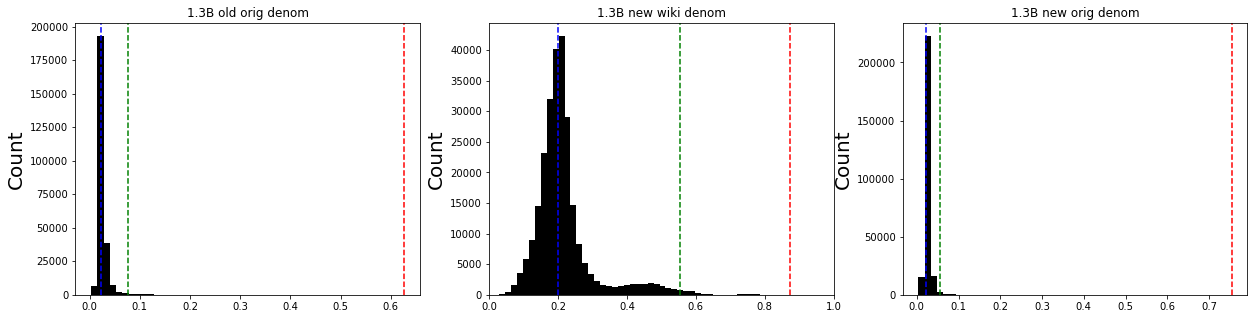

In [9]:
plt.figure(figsize=(21, 5), facecolor="white")

plt.subplot(1, 3, 1)
basic_value_plot(orig_df)
plt.title("1.3B old orig denom")
plt.xlabel("")
#plt.xlim(0, 1)

plt.subplot(1, 3, 2)
basic_value_plot(wd_df)
plt.title("1.3B new wiki denom")
plt.xlabel("")
plt.xlim(0, 1)

plt.subplot(1, 3, 3)
basic_value_plot(od_df)
plt.title("1.3B new orig denom")
plt.xlabel("")
#plt.xlim(0, 1)

plt.show()

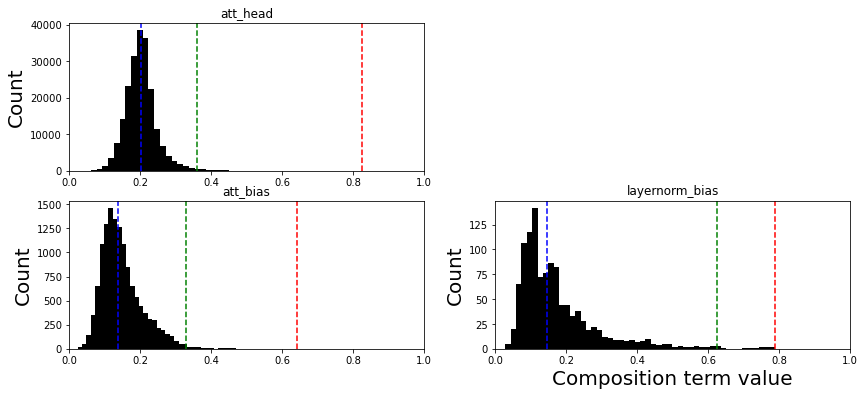

In [10]:
plt.figure(figsize=(14, 6), facecolor="white")

sources = ["att_head", "att_bias", "layernorm_bias"]
for i, src in enumerate(sources):
    j = i + 1 if i < 1 else i + 2  # skipping plot #2
    plt.subplot(2, 2, j)
    basic_value_plot(
        wd_df[(wd_df.src_type == src)
              & (wd_df.dst_type == "att_head")
        ]
    )
    plt.title(src)
    if i < 2:
        plt.xlabel("")
    plt.xlim(0, 1)

plt.show()

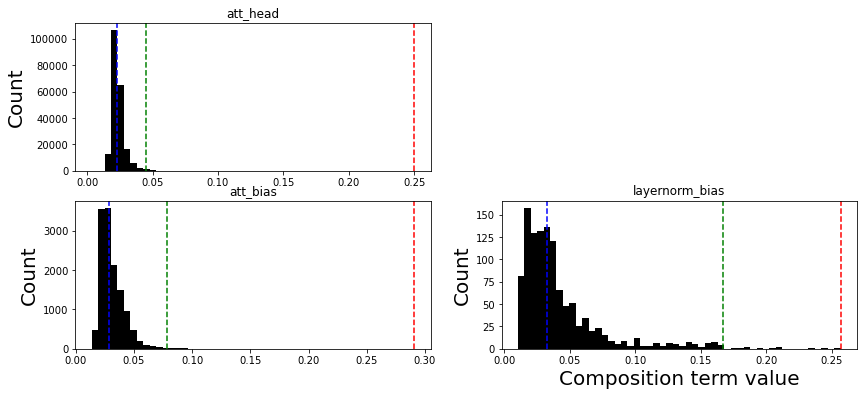

In [11]:
plt.figure(figsize=(14, 6), facecolor="white")

sources = ["att_head", "att_bias", "layernorm_bias"]
for i, src in enumerate(sources):
    j = i + 1 if i < 1 else i + 2  # skipping plot #2
    plt.subplot(2, 2, j)
    basic_value_plot(
        od_df[(od_df.src_type == src)
              & (od_df.dst_type == "att_head")
        ]
    )
    plt.title(src)
    if i < 2:
        plt.xlabel("")
    #plt.xlim(0, 1)

plt.show()

In [12]:
colors = ["#171219", "#DA3E52", "#2E86AB", "#F18F01", "#531CB3"]

In [13]:
def percentiles_by_type(
    df,
    type_colname="term_type",
    src_types=["att_head"],
    dst_types=["att_head"],
    types=["Q", "K", "V"],
):
    subdf = df[(df.src_type.isin(src_types))
               & (df.dst_type == "att_head")]
    
    return plot.percentiles_by_type(
        subdf, type_colname, types=types, colors=colors
    )

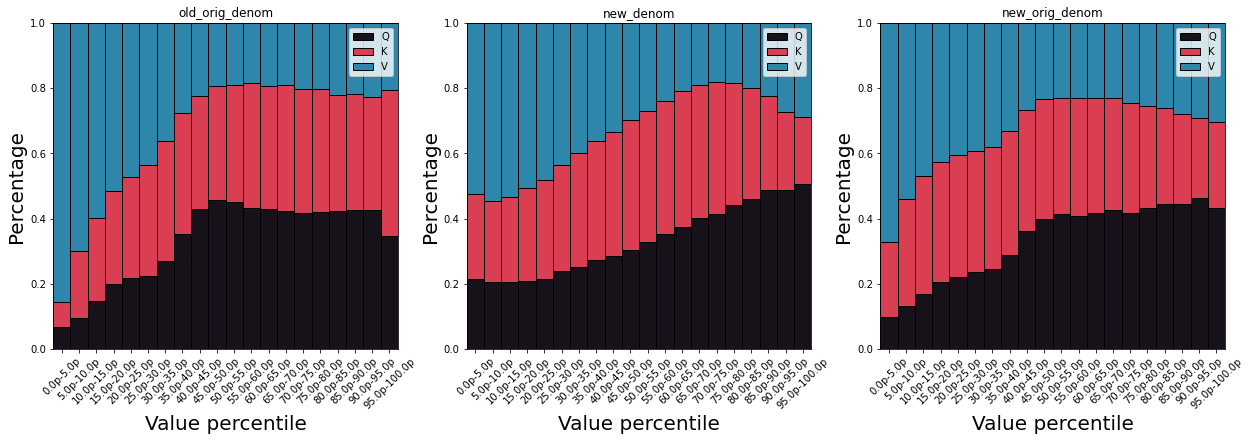

In [14]:
plt.figure(figsize=(21, 6), facecolor="white")

for (i, (name, df)) in enumerate(dataframes.items()):
    plt.subplot(1, 3, i+1)
    percentiles_by_type(df)
    plt.title(name)
    
plt.show()

In [15]:
attonly = wd_df[(wd_df.src_type == "att_head")
                & (wd_df.dst_type == "att_head")
]

In [16]:
attonly_od = od_df[(od_df.src_type == "att_head")
                & (od_df.dst_type == "att_head")
]

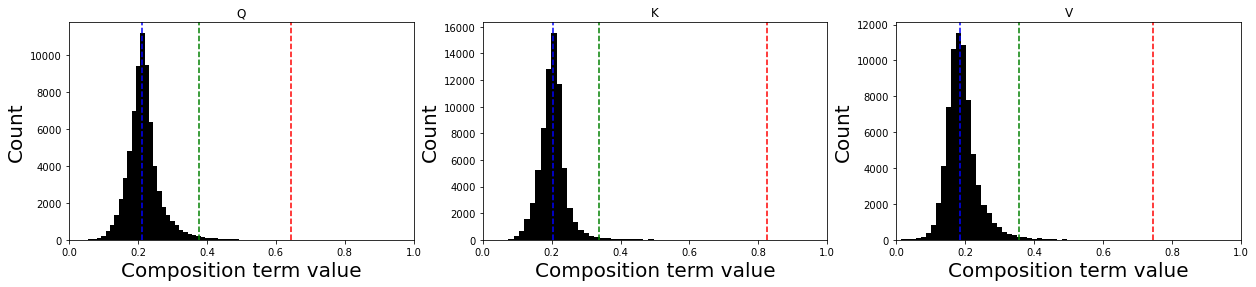

In [17]:
plt.figure(figsize=(21, 4), facecolor="white")

for i, term_type in enumerate(["Q", "K", "V"]):
    plt.subplot(1, 3, i+1)
    basic_value_plot(attonly[attonly.term_type == term_type])
    plt.title(term_type)
    plt.xlim(0, 1)

plt.show()

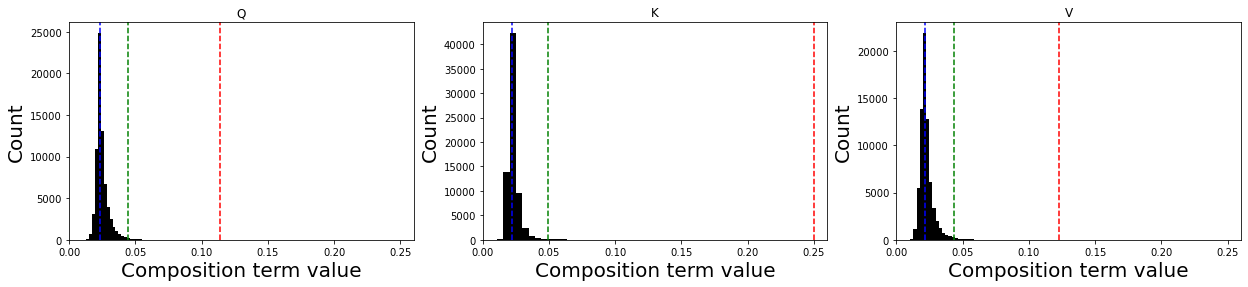

In [18]:
plt.figure(figsize=(21, 4), facecolor="white")

for i, term_type in enumerate(["Q", "K", "V"]):
    plt.subplot(1, 3, i+1)
    basic_value_plot(attonly_od[attonly_od.term_type == term_type])
    plt.title(term_type)
    plt.xlim(0, 0.26)

plt.show()

In [19]:
top1p = attonly[attonly.term_value >= np.percentile(attonly.term_value, 99)]
top5p = attonly[attonly.term_value >= np.percentile(attonly.term_value, 95)]

In [20]:
top1p_od = attonly_od[attonly_od.term_value >= np.percentile(attonly_od.term_value, 99)]
top5p_od = attonly_od[attonly_od.term_value >= np.percentile(attonly_od.term_value, 95)]

In [21]:
def plot_count_by_head(df):
    num_received = np.zeros((24, 16), dtype=np.uint8)
    for i, j in zip(df.dst_block, df.dst_index):
        num_received[i, j] += 1

    plt.imshow(num_received.T)
    plt.xlabel("block", fontsize=20)
    plt.ylabel("attention head", fontsize=20)

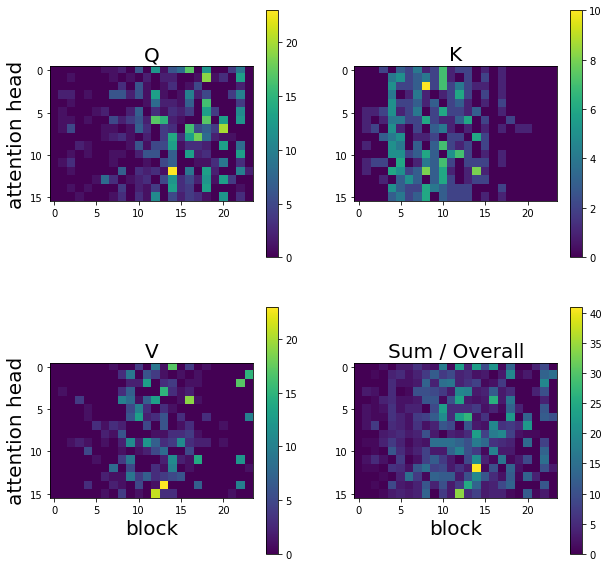

In [22]:
plt.figure(figsize=(10, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_count_by_head(top1p[top1p.term_type == "Q"])
plt.colorbar()
plt.title("Q", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_count_by_head(top1p[top1p.term_type == "K"])
plt.colorbar()
plt.title("K", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_count_by_head(top1p[top1p.term_type == "V"])
plt.colorbar()
plt.title("V", fontsize=20)

plt.subplot(2, 2, 4)
plot_count_by_head(top1p)
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("Sum / Overall", fontsize=20)
plt.ylabel("")

#plt.suptitle("top 1%", fontsize=20)

plt.show()

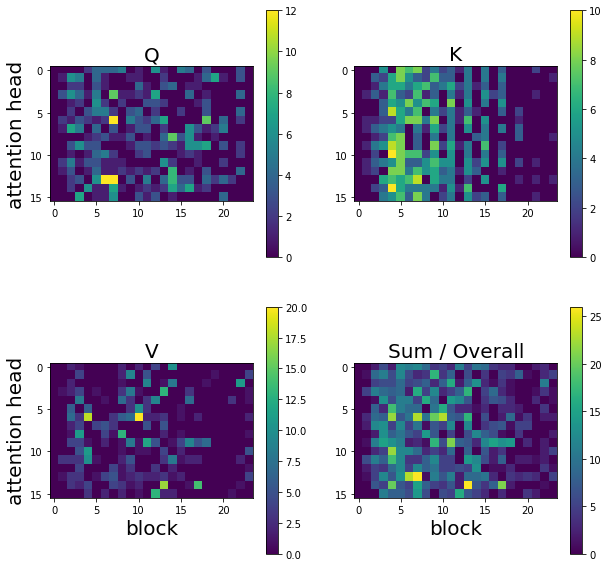

In [23]:
plt.figure(figsize=(10, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_count_by_head(top1p_od[top1p_od.term_type == "Q"])
plt.colorbar()
plt.title("Q", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_count_by_head(top1p_od[top1p_od.term_type == "K"])
plt.colorbar()
plt.title("K", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_count_by_head(top1p_od[top1p_od.term_type == "V"])
plt.colorbar()
plt.title("V", fontsize=20)

plt.subplot(2, 2, 4)
plot_count_by_head(top1p_od)
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("Sum / Overall", fontsize=20)
plt.ylabel("")

#plt.suptitle("top 1%", fontsize=20)

plt.show()

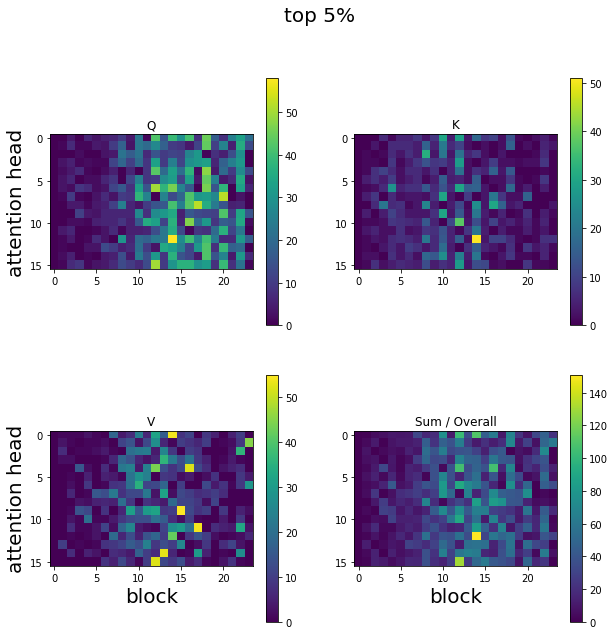

In [24]:
plt.figure(figsize=(10, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_count_by_head(top5p[top5p.term_type == "Q"])
plt.colorbar()
plt.title("Q")
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_count_by_head(top5p[top5p.term_type == "K"])
plt.colorbar()
plt.title("K")
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_count_by_head(top5p[top5p.term_type == "V"])
plt.colorbar()
plt.title("V")

plt.subplot(2, 2, 4)
plot_count_by_head(top5p)
plt.colorbar()
plt.title("Sum / Overall")
plt.ylabel("")

plt.suptitle("top 5%", fontsize=20)

plt.show()

In [25]:
def plot_top_p_block_dists(df, src_types):
    df = df.copy()
    df["1p_grp"] = plot.compute_percentile_bins(df, nbins=100)
    
    subdf = df[(df["1p_grp"] == 100)
               & (df.src_type.isin(src_types))]
    
    diffs = subdf.dst_block - subdf.src_block
    max_block = df.dst_block.max() + 1
    plt.hist(
        diffs,
        bins=np.arange(-1, max_block),
        color="k"
    )
    
    plt.xlabel("Block distance", fontsize=20)
    plt.ylabel("Count", fontsize=20)
    plt.xlim(0, max_block)

In [26]:
def plot_top_p_block_dist_types(df):
    
    def plot_type(typename):
        plot_top_p_block_dists(df, [typename])
        plt.title(typename)
    
    plt.subplot(2, 2, 1)
    plot_type("att_head")
    plt.xlabel("")
    
    plt.subplot(2, 2, 2)
    plot_type("att_bias")
    plt.xlabel("")
    plt.ylabel("")
    
    plt.subplot(2, 2, 3)
    plot_type("mlp_weight")
    
    plt.subplot(2, 2, 4)
    plot_type("mlp_bias")
    plt.ylabel("")

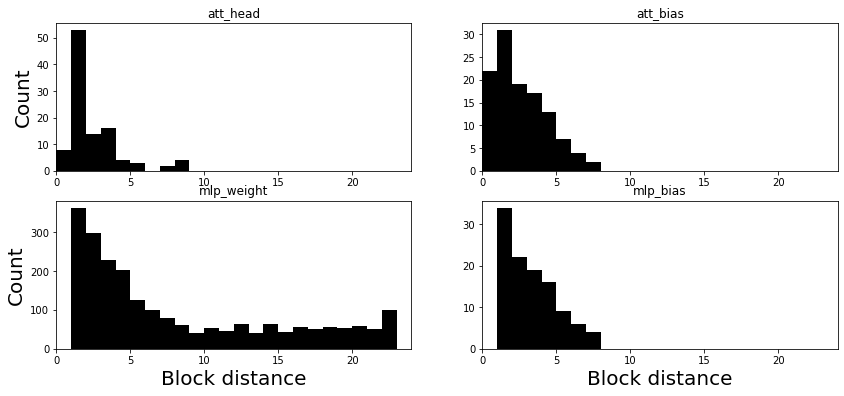

In [27]:
plt.figure(figsize=(14, 6))

plot_top_p_block_dist_types(wd_df)

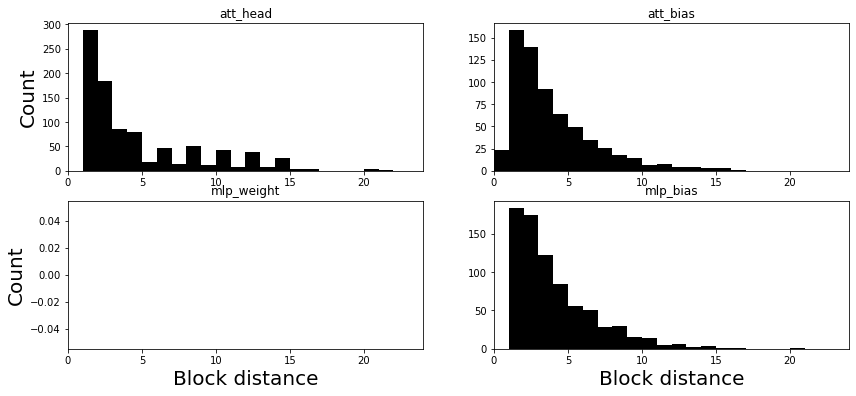

In [28]:
plt.figure(figsize=(14, 6))

plot_top_p_block_dist_types(od_df)

In [29]:
%%time
g = graph.pair_term_graph(attonly)

CPU times: user 5.57 s, sys: 23.5 ms, total: 5.59 s
Wall time: 5.59 s


In [30]:
%%time
g_od = graph.pair_term_graph(attonly_od)

CPU times: user 5.21 s, sys: 35.6 ms, total: 5.24 s
Wall time: 5.25 s


In [31]:
g.vertex_properties["block"].a.max()

PropertyArray(23, dtype=int32)

In [32]:
def ipc_plot(gs, percs, vertex_mask):
    percs = graph.ipc_percentiles(gs, percs, vertex_mask)
    
    plot.plot_ipc_percentiles(percs)

    
def ipc_analysis(g, xmin=70):
    num_blocks = int(g.vertex_properties["block"].a.max()) + 1
    percs = [0, 25, 50, 75, 100]
    
    plt.subplot(2, 3, 1)
    ipc_plot(graph.value_perc_thresholds(g), percs, None)
    plt.title("All vertices", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 4)
    ipc_plot(graph.random_removal(g), percs, None)
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 2)
    ipc_plot(
        graph.value_perc_thresholds(g),
        percs,
        g.vertex_properties["block"].a >= num_blocks // 2,
    )
    plt.title("Second half", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 5)
    ipc_plot(
        graph.random_removal(g),
        percs,
        g.vertex_properties["block"].a >= num_blocks // 2,
    )
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 3)
    ipc_plot(
        graph.value_perc_thresholds(g),
        percs,
        g.vertex_properties["block"].a >= (num_blocks // 4) * 3
    )
    plt.title("Last quarter", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 6)
    ipc_plot(
        graph.random_removal(g),
        percs,
        g.vertex_properties["block"].a >= (num_blocks // 4) * 3
    )
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)


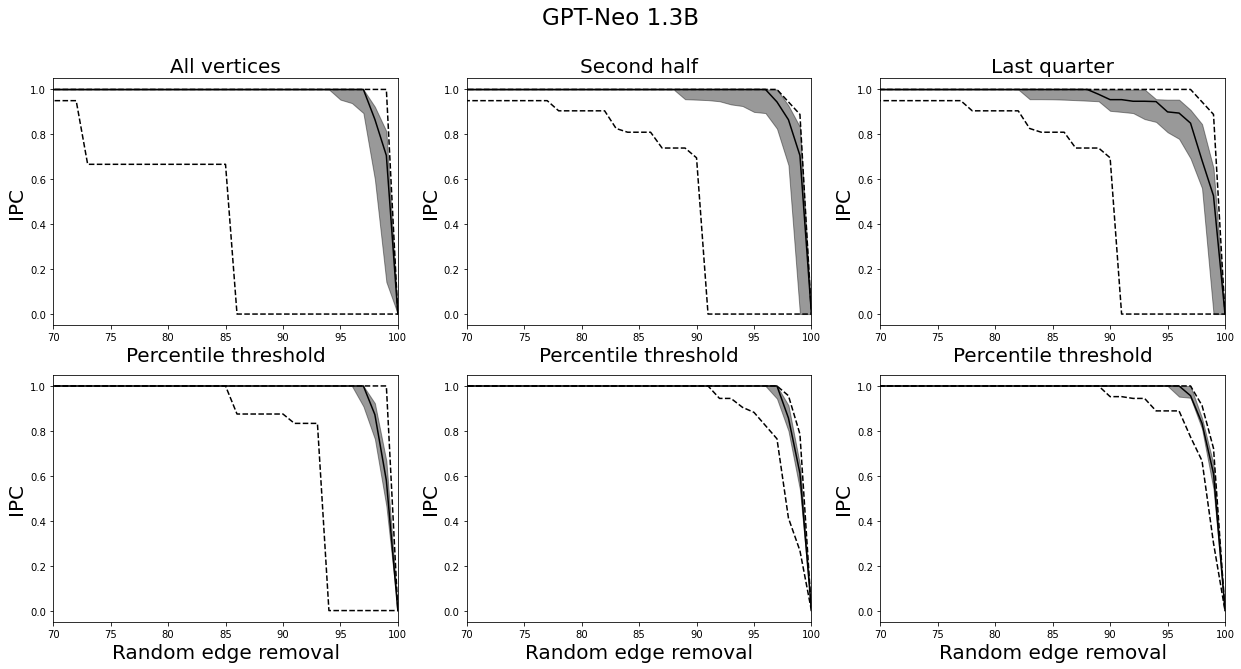

In [33]:
plt.figure(figsize=(21, 10))
ipc_analysis(g)
plt.suptitle("GPT-Neo 1.3B", fontsize=23)
plt.show()

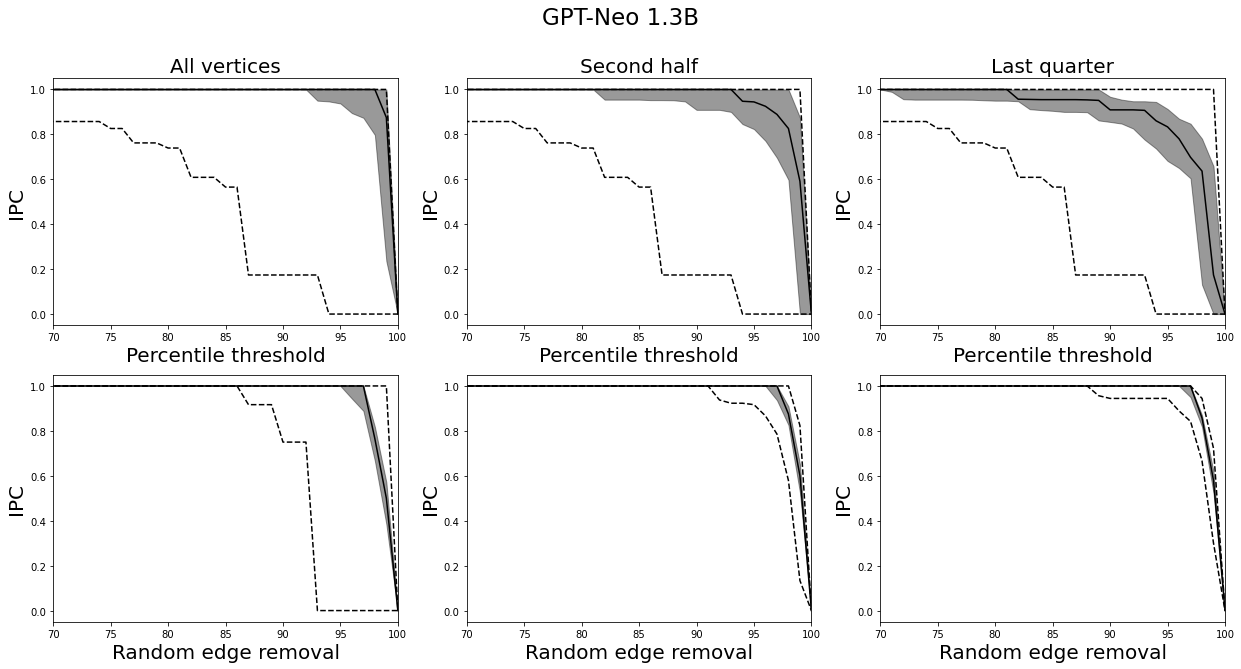

In [34]:
plt.figure(figsize=(21, 10))
ipc_analysis(g_od)
plt.suptitle("GPT-Neo 1.3B", fontsize=23)
plt.show()

In [35]:
def randomp(g: gt.Graph, p: int) -> gt.Graph:
    """Randomly removes 99% of the edges."""
    perm = np.random.permutation(np.arange(len(g.get_edges())))
    mask = np.ones((len(perm),), dtype=bool)
    
    numedges = int(np.ceil(len(perm) / 100)) * p
    inds = perm[:numedges]
    mask[inds] = False
    graph.filter_edges_by_arr(g, mask)
    
    return g

In [36]:
random_ipcs_99 = list()
for i in tqdm(range(1000)):
    g.set_edge_filter(None)
    rand = randomp(g, 99)
    random_ipcs_99.append(graph.input_path_complexities(rand))

random_ipcs_99 = np.array(random_ipcs_99)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.32it/s]


In [37]:
random_ipcs_95 = list()
for i in tqdm(range(1000)):
    g.set_edge_filter(None)
    rand = randomp(g, 95)
    random_ipcs_95.append(graph.input_path_complexities(rand))

random_ipcs_95 = np.array(random_ipcs_95)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.95it/s]


In [38]:
g.set_edge_filter(None)
graph.threshold_value(g, np.percentile(g.edge_properties["term_value"].a, 99))
g_od.set_edge_filter(None)
graph.threshold_value(g_od, np.percentile(g_od.edge_properties["term_value"].a, 99))

orig_ipcs_99 = graph.input_path_complexities(g)
orig_ipcs_99_od = graph.input_path_complexities(g_od)

In [39]:
g.set_edge_filter(None)
graph.threshold_value(g, np.percentile(g.edge_properties["term_value"].a, 95))
g_od.set_edge_filter(None)
graph.threshold_value(g_od, np.percentile(g_od.edge_properties["term_value"].a, 95))

orig_ipcs_95 = graph.input_path_complexities(g)
orig_ipcs_95_od = graph.input_path_complexities(g_od)

In [40]:
def format_axes(ax=None):
    ax = plt.gca() if ax is None else ax

    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["right"].set_linewidth(0)
    ax.spines["top"].set_linewidth(0)

    ax.tick_params(length=5, width=1, which="minor")
    ax.tick_params(length=10, width=1.5, labelsize=18, which="major")

    updates = {"fontname": "Helvetica"}
    xticklabels = ax.get_xticklabels()
    yticklabels = ax.get_yticklabels()
    for l in xticklabels:
        l.update(updates)
    for l in yticklabels:
        l.update(updates)

    xlabel = ax.get_xlabel()
    #ax.set_xlabel(xlabel, fontname="Helvetica")
    ylabel = ax.get_ylabel()
    #ax.set_ylabel(ylabel, fontname="Helvetica")

In [41]:
def plot_comparison(vertex_mask, orig=orig_ipcs_99, randoms=random_ipcs_99):
    orig_ipcs_masked = orig[vertex_mask]
    hists_masked = np.array([np.histogram(row[vertex_mask], bins=bins)[0] for row in randoms])
        
    p2p5 = np.array([np.percentile(hists_masked[:, i], 2.5) for i in range(20)])
    p50 = np.array([np.percentile(hists_masked[:, i], 50) for i in range(20)])
    p97p5 = np.array([np.percentile(hists_masked[:, i], 97.5) for i in range(20)])    
    
    plt.hist(orig_ipcs_masked, bins=bins, edgecolor='k', histtype="step", lw=2)
    plt.xlabel("IPC", fontsize=20)
    plt.ylabel("Count", fontsize=20)

    xs = (bins[:-1] + bins[1:]) / 2
    plt.plot(xs, p50, color='#A29C9B')
    plt.fill_between(xs, p2p5, p97p5, alpha=0.5, color='#A29C9B')
    
    format_axes()

In [42]:
bins = np.array([0.05 * i for i in range(21)])

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


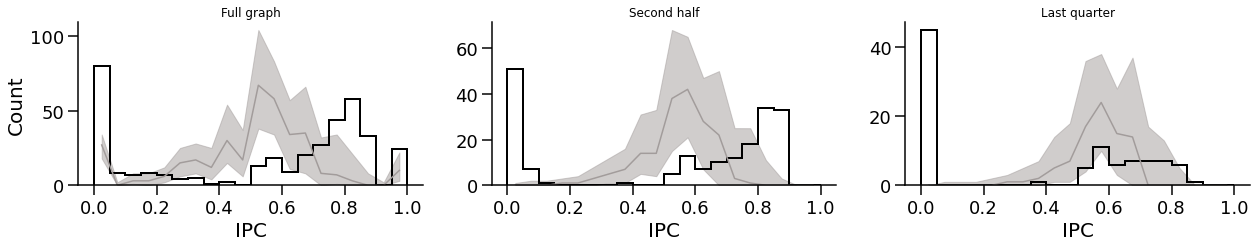

In [43]:
plt.figure(figsize=(21, 3), facecolor="white")

numblocks = g.vertex_properties["block"].a.max() + 1

plt.subplot(1, 3, 1)
plot_comparison(np.ones((len(g.vertex_properties["block"].a),), dtype=bool))
plt.title("Full graph")

plt.subplot(1, 3, 2)
plot_comparison(g.vertex_properties["block"].a >= numblocks / 2)
plt.title("Second half")
plt.ylabel("")

plt.subplot(1, 3, 3)
plot_comparison(g.vertex_properties["block"].a >= numblocks * 3 / 4)
plt.title("Last quarter")
plt.ylabel("")

plt.show()

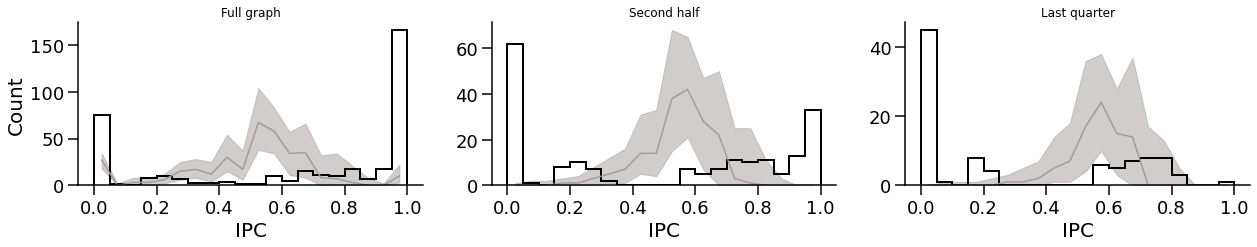

In [44]:
plt.figure(figsize=(21, 3), facecolor="white")

numblocks = g.vertex_properties["block"].a.max() + 1

plt.subplot(1, 3, 1)
plot_comparison(np.ones((len(g.vertex_properties["block"].a),), dtype=bool), orig_ipcs_99_od)
plt.title("Full graph")

plt.subplot(1, 3, 2)
plot_comparison(g.vertex_properties["block"].a >= numblocks / 2, orig_ipcs_99_od)
plt.title("Second half")
plt.ylabel("")

plt.subplot(1, 3, 3)
plot_comparison(g.vertex_properties["block"].a >= numblocks * 3 / 4, orig_ipcs_99_od)
plt.title("Last quarter")
plt.ylabel("")

plt.show()

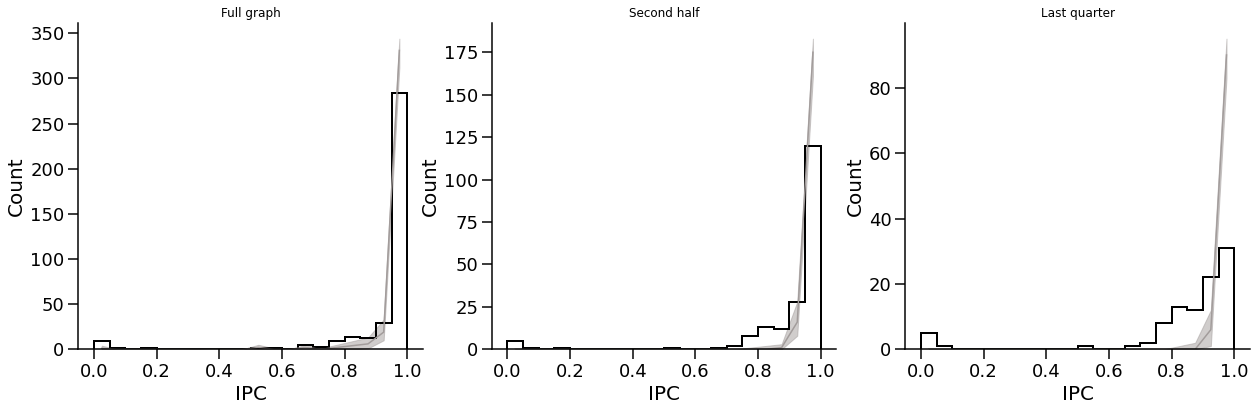

In [45]:
plt.figure(figsize=(21, 6), facecolor="white")

numblocks = g.vertex_properties["block"].a.max() + 1

plt.subplot(1, 3, 1)
plot_comparison(np.ones((len(g.vertex_properties["block"].a),), dtype=bool), orig_ipcs_95, random_ipcs_95)
plt.title("Full graph")

plt.subplot(1, 3, 2)
plot_comparison(g.vertex_properties["block"].a >= numblocks / 2, orig_ipcs_95, random_ipcs_95)
plt.title("Second half")

plt.subplot(1, 3, 3)
plot_comparison(g.vertex_properties["block"].a >= numblocks * 3 / 4, orig_ipcs_95, random_ipcs_95)
plt.title("Last quarter")

plt.show()

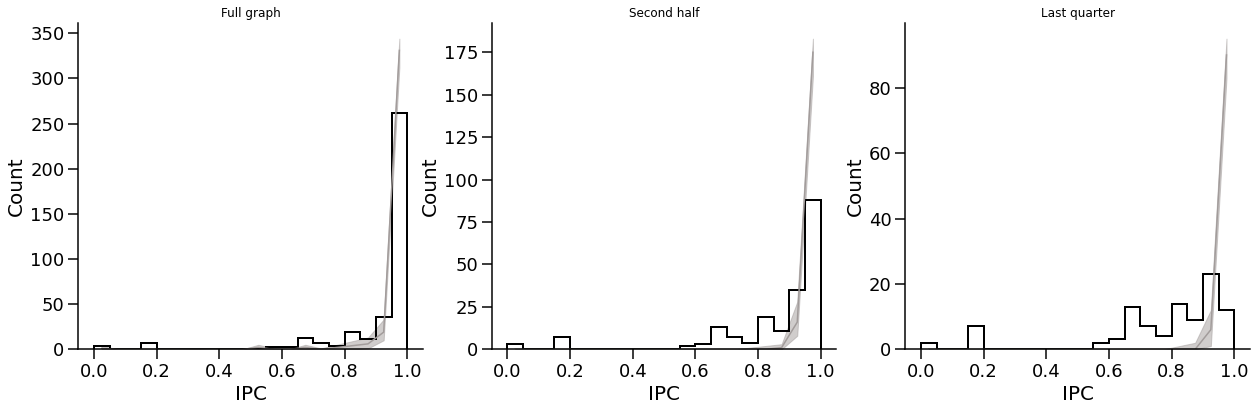

In [46]:
plt.figure(figsize=(21, 6), facecolor="white")

numblocks = g.vertex_properties["block"].a.max() + 1

plt.subplot(1, 3, 1)
plot_comparison(np.ones((len(g.vertex_properties["block"].a),), dtype=bool), orig_ipcs_95_od, random_ipcs_95)
plt.title("Full graph")

plt.subplot(1, 3, 2)
plot_comparison(g.vertex_properties["block"].a >= numblocks / 2, orig_ipcs_95_od, random_ipcs_95)
plt.title("Second half")

plt.subplot(1, 3, 3)
plot_comparison(g.vertex_properties["block"].a >= numblocks * 3 / 4, orig_ipcs_95_od, random_ipcs_95)
plt.title("Last quarter")

plt.show()

# Graph analysis w/ MLPs & LNs

In [50]:
%%time
g = graph.pair_term_graph(wd_df)

CPU times: user 6.49 s, sys: 23.9 ms, total: 6.51 s
Wall time: 6.51 s


In [51]:
%%time
g_od = graph.pair_term_graph(od_df)

CPU times: user 6.47 s, sys: 36 ms, total: 6.51 s
Wall time: 6.51 s


In [52]:
g.vertex_properties["block"].a.max()

PropertyArray(23, dtype=int32)

In [53]:
def ipc_plot(gs, percs, vertex_mask, ceil):
    percs = graph.ipc_percentiles(gs, percs, vertex_mask, ceil)
    
    plot.plot_ipc_percentiles(percs)

    
def ipc_analysis(g, ceil, xmin=70):
    num_blocks = int(g.vertex_properties["block"].a.max()) + 1
    percs = [0, 25, 50, 75, 100]
    
    plt.subplot(2, 3, 1)
    ipc_plot(graph.value_perc_thresholds(g), percs, None, ceil)
    plt.title("All vertices", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 4)
    ipc_plot(graph.random_removal(g), percs, None, ceil)
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 2)
    ipc_plot(
        graph.value_perc_thresholds(g),
        percs,
        g.vertex_properties["block"].a >= num_blocks // 2,
        ceil,
    )
    plt.title("Second half", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 5)
    ipc_plot(
        graph.random_removal(g),
        percs,
        g.vertex_properties["block"].a >= num_blocks // 2,
        ceil,
    )
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 3)
    ipc_plot(
        graph.value_perc_thresholds(g),
        percs,
        g.vertex_properties["block"].a >= (num_blocks // 4) * 3,
        ceil,
    )
    plt.title("Last quarter", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 6)
    ipc_plot(
        graph.random_removal(g),
        percs,
        g.vertex_properties["block"].a >= (num_blocks // 4) * 3,
        ceil,
    )
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)


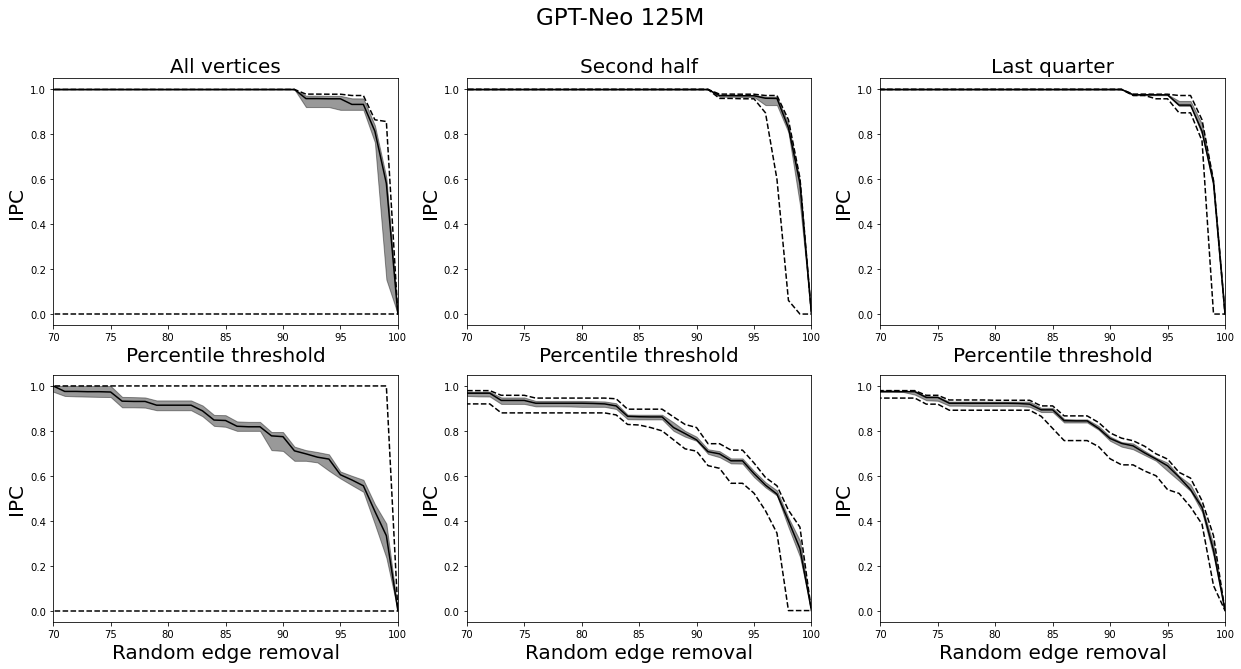

In [54]:
plt.figure(figsize=(21, 10))
ipc_analysis(g, graph.gptneo_ceil(g))
plt.suptitle("GPT-Neo 125M", fontsize=23)
plt.show()

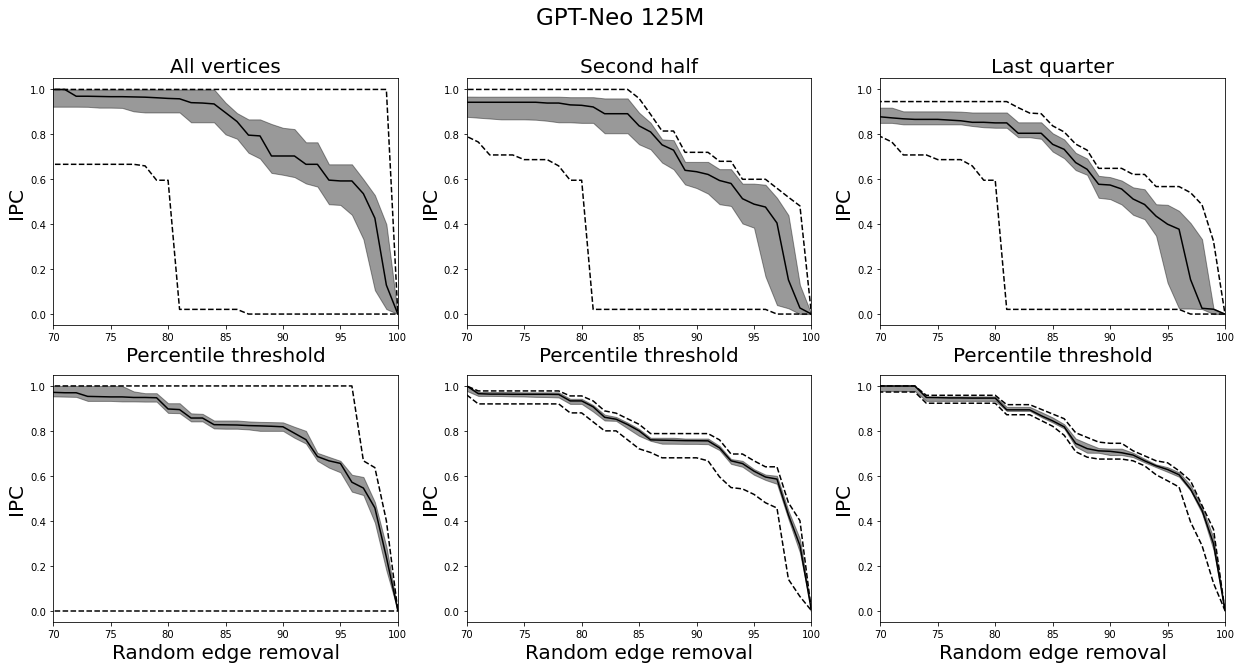

In [55]:
plt.figure(figsize=(21, 10))
ipc_analysis(g_od, graph.gptneo_ceil(g_od))
plt.suptitle("GPT-Neo 125M", fontsize=23)
plt.show()

In [56]:
def random99p(g: gt.Graph) -> gt.Graph:
    """Randomly removes 99% of the edges."""
    perm = np.random.permutation(np.arange(len(g.get_edges())))
    mask = np.ones((len(perm),), dtype=bool)
    
    numedges = int(np.ceil(len(perm) / 100)) * 99
    inds = perm[:numedges]
    mask[inds] = False
    graph.filter_edges_by_arr(g, mask)
    
    return g

In [57]:
ipcs = list()
ceil = graph.gptneo_ceil(g)
for i in tqdm(range(1000)):
    g.set_edge_filter(None)
    rand = random99p(g)
    ipcs.append(graph.input_path_complexities(rand, ceil))

ipcs = np.array(ipcs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.57it/s]


In [58]:
bins = np.array([0.05 * i for i in range(21)])
hists = np.array([np.histogram(row, bins=bins)[0] for row in ipcs])

p2p5 = np.array([np.percentile(hists[:, i], 2.5) for i in range(20)])
p97p5 = np.array([np.percentile(hists[:, i], 97.5) for i in range(20)])

In [59]:
value_thresh = np.percentile(g.edge_properties["term_value"].a, 99)
g.set_edge_filter(None)
graph.threshold_value(g, value_thresh)
graph.threshold_value(g_od, np.percentile(g_od.edge_properties["term_value"].a, 99))

orig_ipcs = graph.input_path_complexities(g, ceil)
orig_ipcs_od = graph.input_path_complexities(g_od, ceil)

In [60]:
def plot_comparison(vertex_mask, orig=orig_ipcs, randoms=ipcs):
    orig_ipcs_masked = orig[vertex_mask]
    hists_masked = np.array([np.histogram(row[vertex_mask], bins=bins)[0] for row in randoms])
        
    p2p5 = np.array([np.percentile(hists_masked[:, i], 2.5) for i in range(20)])
    p50 = np.array([np.percentile(hists_masked[:, i], 50) for i in range(20)])
    p97p5 = np.array([np.percentile(hists_masked[:, i], 97.5) for i in range(20)])    
    
    plt.hist(orig_ipcs_masked, bins=bins, edgecolor='k', histtype="step", lw=2)
    plt.xlabel("IPC", fontsize=20)
    plt.ylabel("Count", fontsize=20)

    xs = (bins[:-1] + bins[1:]) / 2
    plt.plot(xs, p50, color='#A29C9B')
    plt.fill_between(xs, p2p5, p97p5, alpha=0.5, color='#A29C9B')
    
    format_axes()

In [61]:
bins = np.array([0.05 * i for i in range(21)])

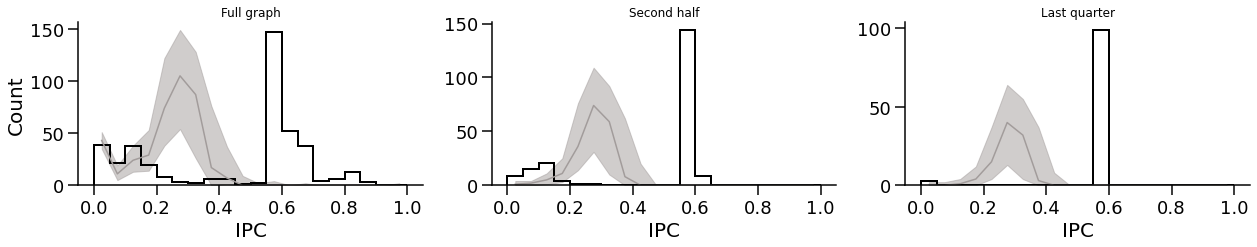

In [62]:
plt.figure(figsize=(21, 3), facecolor="white")

numblocks = g.vertex_properties["block"].a.max() + 1

plt.subplot(1, 3, 1)
plot_comparison(np.ones((len(g.vertex_properties["block"].a),), dtype=bool))
plt.title("Full graph")

plt.subplot(1, 3, 2)
plot_comparison(g.vertex_properties["block"].a >= numblocks / 2)
plt.title("Second half")
plt.ylabel("")

plt.subplot(1, 3, 3)
plot_comparison(g.vertex_properties["block"].a >= numblocks * 3 / 4)
plt.title("Last quarter")
plt.ylabel("")

plt.show()

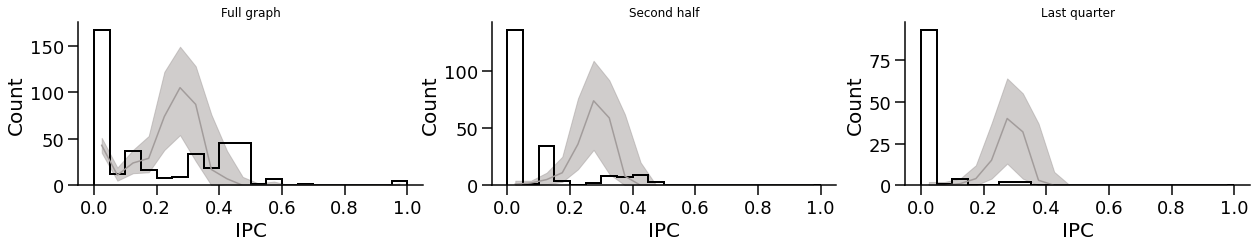

In [63]:
plt.figure(figsize=(21, 3), facecolor="white")

numblocks = g.vertex_properties["block"].a.max() + 1

plt.subplot(1, 3, 1)
plot_comparison(np.ones((len(g.vertex_properties["block"].a),), dtype=bool), orig_ipcs_od)
plt.title("Full graph")

plt.subplot(1, 3, 2)
plot_comparison(g.vertex_properties["block"].a >= numblocks / 2, orig_ipcs_od)
plt.title("Second half")

plt.subplot(1, 3, 3)
plot_comparison(g.vertex_properties["block"].a >= numblocks * 3 / 4, orig_ipcs_od)
plt.title("Last quarter")

plt.show()